Question1:

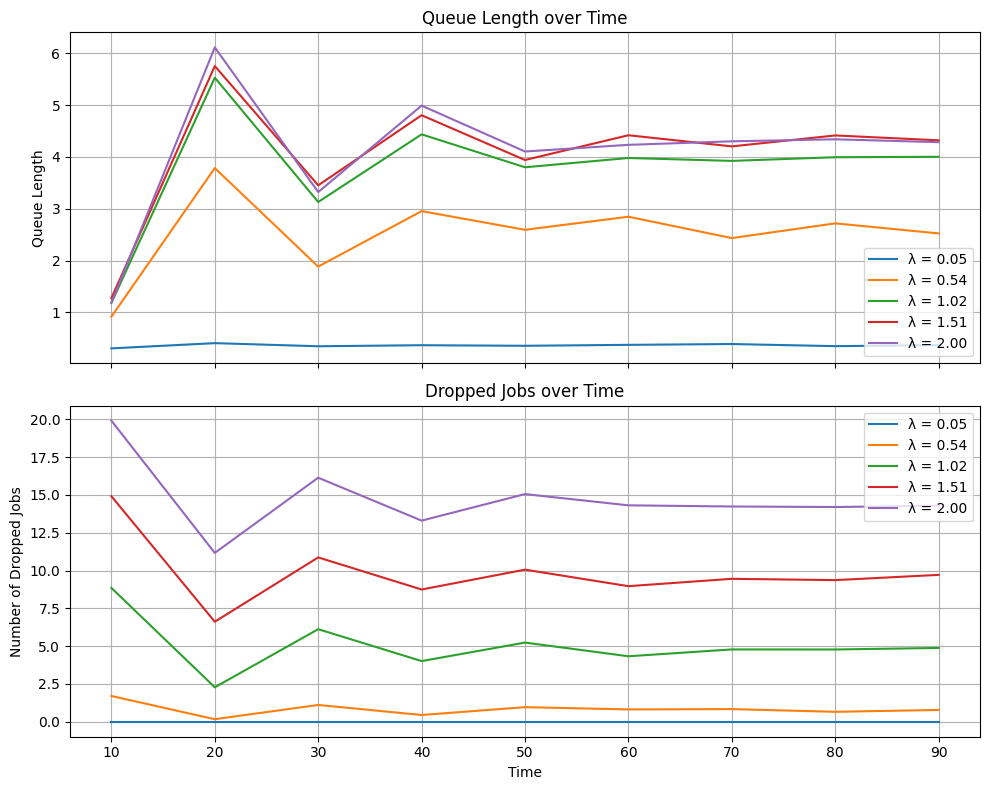

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mu = 1
lambda_range = np.linspace(0.05 * mu, 2 * mu, 5)
capacity = 10
time_end = 100
N = 1000
dt = 10
time_steps = int(time_end / dt)
transient_period = int(0.1 * time_steps)

all_times = np.arange(0, time_end, dt)
queue_lengths = []
dropped_jobs = []

for lam in lambda_range:
    queue_length_avg = np.zeros(time_steps)
    dropped_jobs_avg = np.zeros(time_steps)

    for _ in range(N):
        queue = 0
        jobs_dropped = np.zeros(time_steps)
        queue_length_history = np.zeros(time_steps)

        for t in range(time_steps):
            arrivals = np.random.poisson(lam * dt)
            processing = np.random.poisson(mu * dt) if queue > 0 else 0

            queue += arrivals
            if queue > capacity:
                jobs_dropped[t] = queue - capacity
                queue = capacity

            queue -= processing
            queue = max(queue, 0)
            queue_length_history[t] = queue

        queue_length_avg += queue_length_history
        dropped_jobs_avg += jobs_dropped

    queue_length_avg /= N
    dropped_jobs_avg /= N

    dropped_jobs.append(dropped_jobs_avg[transient_period:])
    queue_lengths.append(queue_length_avg[transient_period:])

all_times_trimmed = all_times[transient_period:]

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for i, lam in enumerate(lambda_range):
    axes[0].plot(all_times_trimmed, queue_lengths[i], label=f"λ = {lam:.2f}")
axes[0].set_ylabel("Queue Length")
axes[0].set_title("Queue Length over Time")
axes[0].grid()
axes[0].legend()

for i, lam in enumerate(lambda_range):
    axes[1].plot(all_times_trimmed, dropped_jobs[i], label=f"λ = {lam:.2f}")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Number of Dropped Jobs")
axes[1].set_title("Dropped Jobs over Time")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()


Question2:

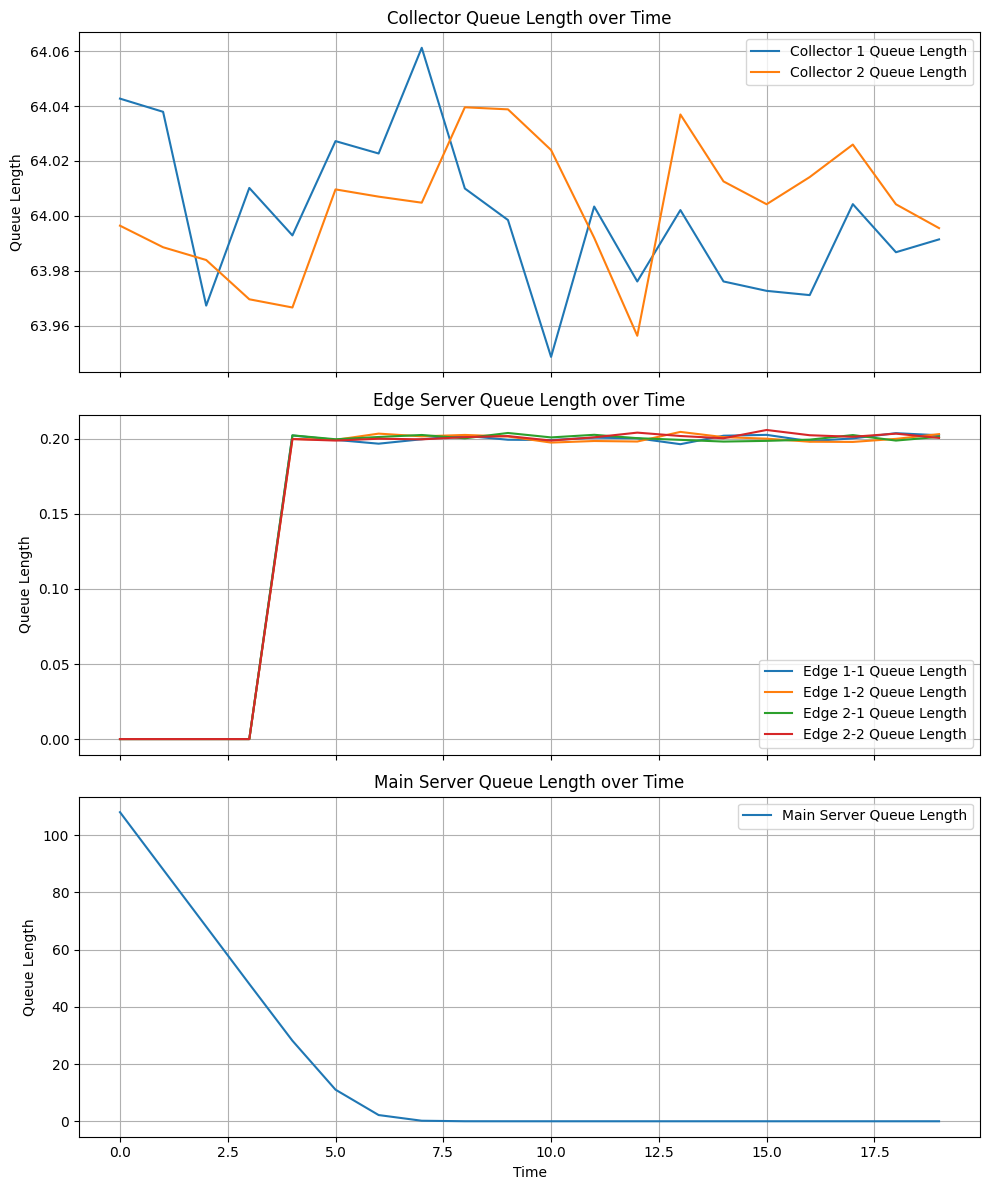

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_main_server(mu_main, time_steps, main_queue, collector_queues):
    main_lengths = np.zeros(time_steps)

    for t in range(time_steps):
        for collector_queue in collector_queues:
            while collector_queue:
                main_queue.append(collector_queue.pop(0))

        num_processed_main = min(len(main_queue), np.random.poisson(mu_main))
        for _ in range(num_processed_main):
            if main_queue:
                main_queue.pop(0)

        main_lengths[t] = len(main_queue)

    return main_lengths

def simulate_collector_server(mu_collector, p, time_steps, collector_queue, processed_memory, edge_queues, k, L):
    collector_lengths = np.zeros(time_steps)

    for t in range(time_steps):
        num_processed_collector = min(len(collector_queue), np.random.poisson(mu_collector))
        for _ in range(num_processed_collector):
            job = collector_queue.pop(0)
            if np.random.rand() < p:
                selected_edge = np.random.randint(L)
                if job in processed_memory[selected_edge]:
                    edge_queues[selected_edge].insert(0, job)
                else:
                    if len(edge_queues[selected_edge]) >= k:
                        edge_queues[selected_edge].pop()
                    edge_queues[selected_edge].append(job)

        collector_lengths[t] = len(collector_queue)

    return collector_lengths

def simulate_edge_server(mu_edge, lambda_edge, time_steps, edge_queue, processed_memory, collector_queue, discard_rate=0.2, ignore_start_time=0.2):
    edge_lengths = np.zeros(time_steps)

    for t in range(time_steps):
        if t < ignore_start_time * time_steps:
            continue

        num_new_jobs = np.random.poisson(lambda_edge)
        for _ in range(num_new_jobs):
            if np.random.rand() > discard_rate:
                edge_queue.append(f"job_{t}_{_}")

        num_processed = min(len(edge_queue), np.random.poisson(mu_edge))
        for _ in range(num_processed):
            job = edge_queue.pop(0) if edge_queue else None
            if job is not None:
                processed_memory.add(job)
                collector_queue.append(job)

        edge_lengths[t] = len(edge_queue)

    return edge_lengths

def simulate_edge_cloud_system(N=100000, time_end=100, dt=5):
    M = 2
    L_per_collector = [2, 2]
    mu_edge = [[1.0, 1.0], [1.0, 1.0]]
    lambda_edge = [[0.5, 0.5], [0.5, 0.5]]
    mu_collector = [sum(mu) for mu in mu_edge]
    mu_main = sum(mu_collector)
    p = 0.2
    k = 5

    time_steps = int(time_end / dt)
    edge_queues = [[list() for _ in range(L)] for L in L_per_collector]
    processed_memory = [[set() for _ in range(L)] for L in L_per_collector]
    collector_queues = [list() for _ in range(M)]
    main_queue = []

    edge_lengths_avg = np.zeros((M, max(L_per_collector), time_steps))
    collector_lengths_avg = np.zeros((M, time_steps))
    main_lengths_avg = np.zeros(time_steps)

    for _ in range(N):
        edge_lengths = [np.zeros((L, time_steps)) for L in L_per_collector]
        collector_lengths = np.zeros((M, time_steps))
        main_lengths = np.zeros(time_steps)

        for t in range(time_steps):
            for j in range(M):
                for i in range(L_per_collector[j]):
                    edge_lengths[j][i] = simulate_edge_server(mu_edge[j][i] * dt, lambda_edge[j][i] * dt, time_steps, edge_queues[j][i], processed_memory[j][i], collector_queues[j], discard_rate=0.2, ignore_start_time=0.2)

                collector_lengths[j, t] = len(collector_queues[j])

            main_lengths = simulate_main_server(mu_main * dt, time_steps, main_queue, collector_queues)

        edge_lengths_avg += np.array(edge_lengths)
        collector_lengths_avg += collector_lengths
        main_lengths_avg += main_lengths

    edge_lengths_avg /= N
    collector_lengths_avg /= N
    main_lengths_avg /= N

    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    for j in range(M):
        axes[0].plot(range(time_steps), collector_lengths_avg[j], label=f"Collector {j+1} Queue Length")
    axes[0].set_ylabel("Queue Length")
    axes[0].set_title("Collector Queue Length over Time")
    axes[0].grid()
    axes[0].legend()

    for j in range(M):
        for i in range(L_per_collector[j]):
            axes[1].plot(range(time_steps), edge_lengths_avg[j][i], label=f"Edge {j+1}-{i+1} Queue Length")
    axes[1].set_ylabel("Queue Length")
    axes[1].set_title("Edge Server Queue Length over Time")
    axes[1].grid()
    axes[1].legend()

    axes[2].plot(range(time_steps), main_lengths_avg, label="Main Server Queue Length")
    axes[2].set_xlabel("Time")
    axes[2].set_ylabel("Queue Length")
    axes[2].set_title("Main Server Queue Length over Time")
    axes[2].grid()
    axes[2].legend()

    plt.tight_layout()
    plt.show()

simulate_edge_cloud_system()


Question3:

In [13]:
import numpy as np

def simulate_edge_server(mu_edge, lambda_edge, time_steps, edge_queue, processed_memory, collector_queue, discard_rate=0.2, ignore_start_time=0.2):
    edge_lengths = np.zeros(time_steps)
    num_exited = 0

    for t in range(time_steps):
        if t < ignore_start_time * time_steps:
            continue

        num_new_jobs = np.random.poisson(lambda_edge)
        for _ in range(num_new_jobs):
            if np.random.rand() > discard_rate:
                edge_queue.append(f"job_{t}_{_}")

        num_processed = min(len(edge_queue), np.random.poisson(mu_edge))
        for _ in range(num_processed):
            job = edge_queue.pop(0) if edge_queue else None
            if job is not None:
                processed_memory.add(job)
                collector_queue.append(job)
                num_exited += 1

        edge_lengths[t] = len(edge_queue)

    return edge_lengths, num_exited

def simulate_collector_server(mu_collector, p, time_steps, collector_queue, processed_memory, edge_queues, k, L):
    collector_lengths = np.zeros(time_steps)

    for t in range(time_steps):
        num_processed_collector = min(len(collector_queue), np.random.poisson(mu_collector))
        for _ in range(num_processed_collector):
            job = collector_queue.pop(0)
            if np.random.rand() < p:
                selected_edge = np.random.randint(L)
                if job in processed_memory[selected_edge]:
                    edge_queues[selected_edge].insert(0, job)
                else:
                    if len(edge_queues[selected_edge]) >= k:
                        edge_queues[selected_edge].pop()
                    edge_queues[selected_edge].append(job)

        collector_lengths[t] = len(collector_queue)

    return collector_lengths

def simulate_main_server(mu_main, time_steps, main_queue, collector_queues):
    main_lengths = np.zeros(time_steps)
    num_exited = 0

    for t in range(time_steps):
        for collector_queue in collector_queues:
            while collector_queue:
                main_queue.append(collector_queue.pop(0))

        num_processed_main = min(len(main_queue), np.random.poisson(mu_main))
        for _ in range(num_processed_main):
            if main_queue:
                main_queue.pop(0)
                num_exited += 1

        main_lengths[t] = len(main_queue)

    return main_lengths, num_exited

def simulate_edge_cloud_system(mu_edge_val, lambda_edge_val, mu_collector_val, mu_main_val, p, k, N, time_end, dt):
    M = 3
    L_per_collector = [5, 5, 5]
    mu_edge = [[mu_edge_val for _ in range(L)] for L in L_per_collector]
    lambda_edge = [[lambda_edge_val for _ in range(L)] for L in L_per_collector]
    mu_collector = [sum(mu) for mu in mu_edge]
    mu_main = mu_main_val

    time_steps = int(time_end / dt)
    edge_queues = [[list() for _ in range(L)] for L in L_per_collector]
    processed_memory = [[set() for _ in range(L)] for L in L_per_collector]
    collector_queues = [list() for _ in range(M)]
    main_queue = []

    total_exits = 0

    for _ in range(N):
        edge_lengths = [np.zeros((L, time_steps)) for L in L_per_collector]
        collector_lengths = np.zeros((M, time_steps))
        main_lengths = np.zeros(time_steps)

        total_exited_for_sim = 0

        for t in range(time_steps):
            for j in range(M):
                for i in range(L_per_collector[j]):
                    edge_lengths[j][i], num_exited_edge = simulate_edge_server(mu_edge[j][i] * dt, lambda_edge[j][i] * dt, time_steps, edge_queues[j][i], processed_memory[j][i], collector_queues[j], discard_rate=0.2, ignore_start_time=0.2)
                    total_exited_for_sim += num_exited_edge

                collector_lengths[j, t] = len(collector_queues[j])

            main_lengths, num_exited_main = simulate_main_server(mu_main * dt, time_steps, main_queue, collector_queues)
            total_exited_for_sim += num_exited_main

        total_exits += total_exited_for_sim

    avg_exit_rate = total_exits / (N * time_steps)
    avg_exit_rate = avg_exit_rate / time_end
    return avg_exit_rate

lambda_values = [3, 6, 9]
mu_edge_val = 10
mu_main_val = 10

p = 0.1
k = 10
N = 100
time_end = 10
dt = 1

import numpy as np

def simulate_edge_server(mu_edge, lambda_edge, time_steps, edge_queue, processed_memory, collector_queue, discard_rate=0.2, ignore_start_time=0.2):
    edge_lengths = np.zeros(time_steps)
    num_exited = 0

    for t in range(time_steps):
        if t < ignore_start_time * time_steps:
            continue

        num_new_jobs = np.random.poisson(lambda_edge)
        for _ in range(num_new_jobs):
            if np.random.rand() > discard_rate:
                edge_queue.append(f"job_{t}_{_}")

        num_processed = min(len(edge_queue), np.random.poisson(mu_edge))
        for _ in range(num_processed):
            job = edge_queue.pop(0) if edge_queue else None
            if job is not None:
                processed_memory.add(job)
                collector_queue.append(job)
                num_exited += 1

        edge_lengths[t] = len(edge_queue)

    return edge_lengths, num_exited

def simulate_collector_server(mu_collector, p, time_steps, collector_queue, processed_memory, edge_queues, k, L):
    collector_lengths = np.zeros(time_steps)

    for t in range(time_steps):
        num_processed_collector = min(len(collector_queue), np.random.poisson(mu_collector))
        for _ in range(num_processed_collector):
            job = collector_queue.pop(0)
            if np.random.rand() < p:
                selected_edge = np.random.randint(L)
                if job in processed_memory[selected_edge]:
                    edge_queues[selected_edge].insert(0, job)
                else:
                    if len(edge_queues[selected_edge]) >= k:
                        edge_queues[selected_edge].pop()
                    edge_queues[selected_edge].append(job)

        collector_lengths[t] = len(collector_queue)

    return collector_lengths

def simulate_main_server(mu_main, time_steps, main_queue, collector_queues):
    main_lengths = np.zeros(time_steps)
    num_exited = 0

    for t in range(time_steps):
        for collector_queue in collector_queues:
            while collector_queue:
                main_queue.append(collector_queue.pop(0))

        num_processed_main = min(len(main_queue), np.random.poisson(mu_main))
        for _ in range(num_processed_main):
            if main_queue:
                main_queue.pop(0)
                num_exited += 1

        main_lengths[t] = len(main_queue)

    return main_lengths, num_exited

def simulate_edge_cloud_system(mu_edge_val, lambda_edge_val, mu_collector_val, mu_main_val, p, k, N, time_end, dt):
    M = 3
    L_per_collector = [5, 5, 5]
    mu_edge = [[mu_edge_val for _ in range(L)] for L in L_per_collector]
    lambda_edge = [[lambda_edge_val for _ in range(L)] for L in L_per_collector]
    mu_collector = [sum(mu) for mu in mu_edge]
    mu_main = mu_main_val

    time_steps = int(time_end / dt)
    edge_queues = [[list() for _ in range(L)] for L in L_per_collector]
    processed_memory = [[set() for _ in range(L)] for L in L_per_collector]
    collector_queues = [list() for _ in range(M)]
    main_queue = []

    total_exits = 0

    for _ in range(N):
        edge_lengths = [np.zeros((L, time_steps)) for L in L_per_collector]
        collector_lengths = np.zeros((M, time_steps))
        main_lengths = np.zeros(time_steps)

        total_exited_for_sim = 0

        for t in range(time_steps):
            for j in range(M):
                for i in range(L_per_collector[j]):
                    edge_lengths[j][i], num_exited_edge = simulate_edge_server(mu_edge[j][i] * dt, lambda_edge[j][i] * dt, time_steps, edge_queues[j][i], processed_memory[j][i], collector_queues[j], discard_rate=0.2, ignore_start_time=0.2)
                    total_exited_for_sim += num_exited_edge

                collector_lengths[j, t] = len(collector_queues[j])

            main_lengths, num_exited_main = simulate_main_server(mu_main * dt, time_steps, main_queue, collector_queues)
            total_exited_for_sim += num_exited_main

        total_exits += total_exited_for_sim

    avg_exit_rate = total_exits / (N * time_steps)
    avg_exit_rate = avg_exit_rate / time_end
    return avg_exit_rate

lambda_values = [3, 6, 9]
mu_edge_val = 10
mu_main_val = 10

p = 0.1
k = 10
N = 100
time_end = 10
dt = 1

for lambda_edge_val in lambda_values:
    avg_exit_rate = simulate_edge_cloud_system(mu_edge_val, lambda_edge_val, mu_edge_val, mu_main_val, p, k, N, time_end, dt)
    print(f"Average exit rate for lambda = {lambda_edge_val}: {avg_exit_rate:.2f}")

Average exit rate for lambda = 3: 38.67
Average exit rate for lambda = 6: 67.63
Average exit rate for lambda = 9: 96.38


Question4:

In [10]:
import numpy as np
import matplotlib.pyplot as plt

class TaskProcessor:
    def __init__(self, rate, max_queue_size, num_primary_workers, num_secondary_workers, retry_probability):
        self.rate = rate
        self.max_queue_size = max_queue_size
        self.num_primary_workers = num_primary_workers
        self.num_secondary_workers = num_secondary_workers
        self.retry_probability = retry_probability
        self.worker_queues = [[[] for _ in range(num_secondary_workers)] for _ in range(num_primary_workers)]
        self.primary_queues = [[] for _ in range(num_primary_workers)]
        self.final_task_queue = []
        self.next_task_completion = [[np.inf for _ in range(num_secondary_workers)] for _ in range(num_primary_workers)]
        self.next_primary_completion = [np.inf for _ in range(num_primary_workers)]
        self.next_final_task_completion = np.inf
        self.lost_task_count = 0
        self.retried_task_count = 0
        self.completed_task_count = 0

    def transition_probability(self):
        return 2 * (1 / (1 + np.exp(-0.25 * self.rate)) - 0.5)

    def handle_new_task(self, task_arrival):
        primary_worker_idx = np.random.randint(self.num_primary_workers)
        secondary_worker_idx = np.random.randint(self.num_secondary_workers)

        if len(self.worker_queues[primary_worker_idx][secondary_worker_idx]) < self.max_queue_size:
            self.worker_queues[primary_worker_idx][secondary_worker_idx].append(task_arrival)
        else:
            self.lost_task_count += 1

        if len(self.worker_queues[primary_worker_idx][secondary_worker_idx]) == 1:
            self.next_task_completion[primary_worker_idx][secondary_worker_idx] = np.random.exponential(1 / self.rate)

    def process_secondary_worker_completion(self, current_time):
        for primary_idx in range(self.num_primary_workers):
            for secondary_idx in range(self.num_secondary_workers):
                if current_time == self.next_task_completion[primary_idx][secondary_idx]:
                    self.worker_queues[primary_idx][secondary_idx].pop(0)
                    if np.random.rand() < self.retry_probability:
                        self.retried_task_count += 1
                        if len(self.worker_queues[primary_idx][secondary_idx]) < self.max_queue_size:
                            self.worker_queues[primary_idx][secondary_idx].append(current_time)
                        else:
                            self.lost_task_count += 1
                    else:
                        self.primary_queues[primary_idx].append(current_time)

                    if self.worker_queues[primary_idx][secondary_idx]:
                        self.next_task_completion[primary_idx][secondary_idx] = np.random.exponential(1 / self.rate)
                    else:
                        self.next_task_completion[primary_idx][secondary_idx] = np.inf

                    if len(self.primary_queues[primary_idx]) == 1:
                        self.next_primary_completion[primary_idx] = np.random.exponential(1 / self.rate)

    def process_primary_worker_completion(self, current_time):
        primary_idx = self.next_primary_completion.index(current_time)
        self.primary_queues[primary_idx].pop(0)
        self.final_task_queue.append(current_time)

        if self.primary_queues[primary_idx]:
            self.next_primary_completion[primary_idx] = np.random.exponential(1 / self.rate)
        else:
            self.next_primary_completion[primary_idx] = np.inf

        if len(self.final_task_queue) == 1:
            self.next_final_task_completion = np.random.exponential(1 / self.rate)

    def process_final_task_completion(self):
        self.final_task_queue.pop(0)
        self.completed_task_count += 1

        if self.final_task_queue:
            self.next_final_task_completion = np.random.exponential(1 / self.rate)
        else:
            self.next_final_task_completion = np.inf

for (param_A, param_B), optimal_rate in optimal_mus.items():
   print(f'Optimal Rate for A={param_A}, B={param_B}: {optimal_rate:.2f}')